In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import precision_recall_fscore_support, mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
import matplotlib.pyplot as plt

from models import NNClassifier



from util import load_data, scatter_density, scatter_3D,  train_test_split_Time,\
    get_variability_reduction, get_importance,plot_tccon, plot_map, make_prediction,normalize_per_SA, feature_selector, \
    get_RMSE, filter_TCCON, bias_correct, calc_SA_bias, plot_qf_map, hex_plot




In [2]:
def generate_training_set(train_years,tccon_flag = False,mode='LndNDGL',qf=None,preload_IO=True,footprint=0,Steffen_IO=False):
    '''
    :param years: list of years for training
    :param tccon_flag: bool, if True use tccon with SA for training
    '''
    data = []
    # for year in train_years:
    #     if not tccon_flag:
    #         data.append(load_data(year,mode,qf=qf,preload_IO=preload_IO,footprint=footprint,Steffen_IO=Steffen_IO))
    #     else:
    #         d = load_data(year,mode,qf=qf,preload_IO=preload_IO, footprint=footprint,Steffen_IO=Steffen_IO)
    #         data_tccon = d[d.xco2tccon.notnull()]
    #         data_tccon.loc[:,'xco2_raw'] = data_tccon.loc[:,'xco2tccon']
    #         d = pd.concat([d,data_tccon])
    #         data.append(d)
    if mode == 'all':
        for year in train_years:
            full = load_data(year,mode,qf=qf,preload_IO=preload_IO,footprint=footprint,Steffen_IO=Steffen_IO)
            subset = full.sample(n = int(1E+6),axis = 0)
            data.append(subset)
    else:    
        for year in train_years:
            data.append(load_data(year,mode,qf=qf,preload_IO=preload_IO,footprint=footprint,Steffen_IO=Steffen_IO))
    return pd.concat(data)

In [ ]:
tcconRidgeDirString = '/Users/williamkeely/Desktop/B11/current/bias_models_current/current/V4_5_nofoot_noTCsplit_dws_xco2_TCCON_biasall_all_RF0/'  # path to 1st bias model directory
rfDirString = '/Users/williamkeely/Desktop/B11/current/bias_models_current/current/V4_5_precRF_noTC_nofoot_noTCsplit_xco2raw_SA_biasall_all_RF0/'  # path to 2nd bias model directory
qfModelDirString = '/Users/williamkeely/Desktop/B11/current/MLQF_models'

train_years = [2018,2019,2020,2022]

data_train = generate_training_set(train_years=train_years,tccon_flag = False,mode='all',qf=None,preload_IO=True,footprint=0,Steffen_IO=False)

data_test = load_data(2021, 'all', verbose_IO=True, qf=None, preload_IO=True, footprint=0, Steffen_IO=False)
data_qf = data_test.copy(deep=True) # deep copy for plotting
data_qf = data_qf[data_qf['xco2_quality_flag'] == 0] # use to evaluate difference between MLQF and B11 QF
data_train['xco2_ret'] = data_train['xco2_raw']    
data_test['xco2_ret'] = data_test['xco2_raw']    
# make bias correction 1
vars = ['xco2_raw']
data_train = bias_correct(tcconRidgeDirString, data_train, vars)
data_test = bias_correct(tcconRidgeDirString, data_test, vars)

# make bias correction 2 # if we have a two step bias corr model
data_train = bias_correct(rfDirString, data_train, vars)
data_test = bias_correct(rfDirString, data_test, vars)

data_train['xco2MLcorr'] =  data_train['xco2_raw']
data_test['xco2MLcorr'] = data_test['xco2_raw'] 

# recalculate small area bias
data_test.sort_values('SA', inplace=True)
XCO2 = data_test.loc[:, 'xco2MLcorr'].to_numpy()
SA = data_test.loc[:, 'SA'].to_numpy()
data_test.loc[:, 'xco2raw_SA_bias'] = calc_SA_bias(XCO2, SA)
    

In [ ]:
pd.set_option('display.max_columns', 200)
print(data_train.columns.tolist())


In [ ]:
plt.hist(abs(data_test['xco2raw_SA_bias']), bins = 120, histtype = 'step', color = 'red', linewidth = 3)
plt.xlim(0,4)
plt.axvline(1, color = 'black', linestyle = 'dotted', linewidth = 3)
plt.xlabel('\u0394' + 'XCO2 SA', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [ ]:
error_threshold = 1.0

# change to land or ocean only
data_train = data_train[data_train['land_water_indicator'] == 0]
data_test = data_test[data_test['land_water_indicator'] == 0]

# binary flag
# y_train_c = (data_train.loc[:, 'xco2raw_SA_bias']  >= error_threshold) | (data_train.loc[:,'xco2raw_SA_bias'] <= -error_threshold)# threshold for what classification.
# y_test_c = (data_test.loc[:, 'xco2raw_SA_bias']  >= error_threshold) | (data_test.loc[:,'xco2raw_SA_bias'] <= -error_threshold)

# ternary flag
# y_train_c = data_test.loc[:,'xco2raw_SA_bias'].cut(bins = [0.6,error_threshold,data_train.loc[:'xco2raw_SA_bias'].max()])
# y_test_c = data_test.loc[:,'xco2raw_SA_bias'].cut(bins = [0.6,error_threshold,data_train.loc[:'xco2raw_SA_bias'].max()])

# regression and chop
# y_train_r = np.abs(data_train.loc[:,'xco2_ret'] - data_train.loc[:,'xco2MLcorr'])
# y_test_r = np.abs(data_test.loc[:,'xco2_ret'] - data_test.loc[:,'xco2MLcorr'])
y_train_r = np.abs(data_train.loc[:,'xco2raw_SA_bias'])
y_test_r = np.abs(data_test.loc[:,'xco2raw_SA_bias'])

<h2> Absolute DiffXCO2 regression & 'Chop' </h2>

Good results for SA data but may be overfitting as TCCON result is poor (median diffxco2 > 1)

In [ ]:
# land vars
feats = ['co2_grad_del','dpfrac', 'rms_rel_o2a','aod_strataer', 't700','footprint',
                     'dp_o2a', 'aod_ice','dws','h_continuum_sco2','solar_azimuth_angle']

X_train = data_train[feats]
X_test = data_test[feats]



M = RandomForestRegressor(n_estimators=100,
                                   max_depth=12,
                                   max_samples=len(X_train)//2,
                                   min_samples_split=40,
                                   min_samples_leaf=10,
                                   min_weight_fraction_leaf=0.0,
                                   max_features='sqrt',
                                   max_leaf_nodes=None,
                                   min_impurity_decrease=0.0,
                                   bootstrap=True,
                                   oob_score=False,
                                   n_jobs=16,
                                   random_state=None,
                                   verbose=0,
                                   warm_start=False)

In [ ]:
# fit regressor
M.fit(X_train, y_train_r)
preds = M.predict(X_test)
mean_squared_error(preds,y_test_r, squared = False)

In [ ]:
preds.max()

In [ ]:
data_test['MLQF_true'] = pd.cut(y_test_r, bins=[0,1.15,y_test_r.max()], labels=[0,1], right=False)
data_test['MLQF'] = pd.cut(preds, bins=[0,1.15,preds.max()], labels=[0,1], right=False)

In [ ]:
data_test.loc[:,'MLQF_true'].value_counts().plot(kind='barh')

In [ ]:
data_test['MLQF']

In [ ]:
data_test = data_test.dropna(subset=['MLQF','MLQF_true'])
data_test['MLQF_true'].isnull().sum()


In [ ]:
len(data_test)

In [ ]:
data_mlqf = data_test[data_test['MLQF'] == 0]
print(get_RMSE(data_mlqf['xco2raw_SA_bias']))
print(data_mlqf['xco2tccon'].std())
prec, recal, F1, _ = precision_recall_fscore_support(data_test['MLQF'], data_test['MLQF_true'])
print('[QF=0, QF=1]')
print('Precision Test :', prec)
print('Recall Test :', recal)
print('F1 Test :', F1)

In [ ]:
len(data_mlqf)/len(data_test) * 100

In [ ]:
TCCON_names = np.unique(data_train['tccon_name'].to_numpy())
TCCON_names = TCCON_names[TCCON_names != 'pasadena01']
TCCON_names = TCCON_names[TCCON_names != 'xianghe01']
print('TCCON Stations : ', TCCON_names)

xco2ML_std, xco2ML_mean, xco2B11_std, xco2B11_mean, xco2raw_std, xco2raw_mean, xco2ML_RMSE_QF0, xco2B11_RMSE, xco2raw_RMSE = plot_tccon(data_mlqf,
                                                                                               TCCON_names,
                                                                                               save_fig=None,
                                                                                               path=None,
                                                                                               name=None)

In [ ]:
# TODO try appending TCCON data.

In [ ]:
xco2ML_RMSE_QF0

<h2> Ternary Flag (no spatial weighting) </h2>

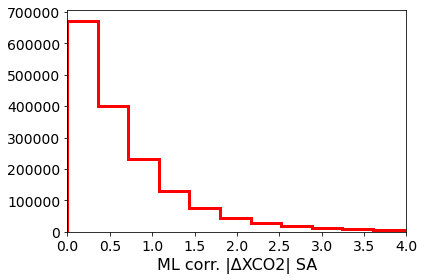

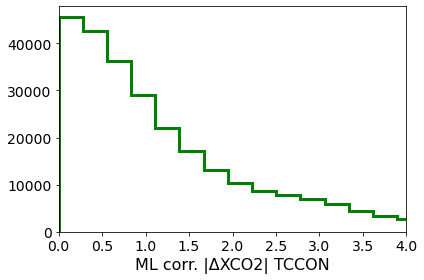

In [60]:
plt.hist(abs(data_test['xco2raw_SA_bias']), bins = 120, histtype = 'step', color = 'red', linewidth = 3)
plt.xlim(0,4)
# plt.axvline(0.5, color = 'black', linestyle = 'dotted', linewidth = 3)
# plt.axvline(1.15, color = 'black', linestyle = 'dotted', linewidth = 3)
plt.xlabel('ML corr. |'+'\u0394' + 'XCO2| SA', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()

plt.savefig('hist_abs_sa.png',dpi=200)
plt.show()

plt.hist(abs(data_test['xco2_raw'] - data_test['xco2tccon']), bins = 120, histtype = 'step', color = 'green', linewidth = 3)
plt.xlim(0,4)
# plt.axvline(0.5, color = 'black', linestyle = 'dotted', linewidth = 3)
# plt.axvline(1.15, color = 'black', linestyle = 'dotted', linewidth = 3)
plt.xlabel('ML corr. |'+ '\u0394' + 'XCO2| TCCON', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.savefig('hist_abs_tccon.png',dpi=200)
plt.show()

In [ ]:
tcconRidgeDirString = '/Users/williamkeely/Desktop/B11/current/bias_models_current/current/V4_5_nofoot_noTCsplit_dws_xco2_TCCON_biasall_all_RF0/'  # path to 1st bias model directory
rfDirString = '/Users/williamkeely/Desktop/B11/current/bias_models_current/current/V4_5_precRF_noTC_nofoot_noTCsplit_xco2raw_SA_biasall_all_RF0/'  # path to 2nd bias model directory
qfModelDirString = '/Users/williamkeely/Desktop/B11/current/MLQF_models'

train_years = [2018,2019,2020]

data_train = generate_training_set(train_years=train_years,tccon_flag = False,mode='all',qf=None,preload_IO=True,footprint=0,Steffen_IO=False)

data_test = load_data(2021, 'all', verbose_IO=True, qf=None, preload_IO=True, footprint=0, Steffen_IO=False)

# set land fraction 0 = land, 1 = ocean
data_train = data_train[data_train['land_water_indicator'] == 0]
data_test = data_test[data_test['land_water_indicator'] == 0]


data_qf = data_test.copy(deep=True) # deep copy for plotting
data_qf = data_qf[data_qf['xco2_quality_flag'] == 0] # use to evaluate difference between MLQF and B11 QF
data_train['xco2_ret'] = data_train['xco2_raw']    
data_test['xco2_ret'] = data_test['xco2_raw']    
# make bias correction 1
vars = ['xco2_raw']
data_train = bias_correct(tcconRidgeDirString, data_train, vars)
data_test = bias_correct(tcconRidgeDirString, data_test, vars)

# make bias correction 2 # if we have a two step bias corr model
data_train = bias_correct(rfDirString, data_train, vars)
data_test = bias_correct(rfDirString, data_test, vars)

data_train['xco2MLcorr'] =  data_train['xco2_raw']
data_test['xco2MLcorr'] = data_test['xco2_raw'] 

# recalculate small area bias
data_test.sort_values('SA', inplace=True)
XCO2 = data_test.loc[:, 'xco2MLcorr'].to_numpy()
SA = data_test.loc[:, 'SA'].to_numpy()
data_test.loc[:, 'xco2raw_SA_bias'] = calc_SA_bias(XCO2, SA)
    

loading data from 2018...
loading data from 2019...
loading data from 2020...
loading data from 2021...
making predictions
making predictions
making predictions
making predictions
recalculating SA bias


In [ ]:
# land vars
feats = ['co2_grad_del','dpfrac','aod_strataer','dp_o2a','h_continuum_sco2','aod_ice','ice_height','h_continuum_o2a','aod_sulfate','co2_ratio','albedo_sco2', 'rms_rel_wco2',
                   'rms_rel_sco2','footprint','solar_zenith_angle']



y_train = pd.cut(np.abs(data_train['xco2raw_SA_bias']), bins=[0,0.5,1.15,data_train['xco2raw_SA_bias'].max()+1], labels=[0,1,2], right=False)
y_test = pd.cut(np.abs(data_test['xco2raw_SA_bias']), bins=[0,0.5,1.15,data_test['xco2raw_SA_bias'].max()+1], labels=[0,1,2], right=False)
data_train['MLQF_true'] = y_train
data_test['MLQF_true'] = y_test


data_train = data_train.dropna(subset=['MLQF_true'])
data_test = data_test.dropna(subset=['MLQF_true'])

y_train = data_train['MLQF_true']
y_test = data_test['MLQF_true']

y_test.isnull().sum()

X_train = data_train[feats]
X_test = data_test[feats]



M = RandomForestClassifier(n_estimators=100,
                                   max_depth=12,
                                   max_samples=len(X_train)//2,
                                   min_samples_split=40,
                                   min_samples_leaf=10,
                                   min_weight_fraction_leaf=0.0,
                                   max_features='sqrt',
                                   max_leaf_nodes=None,
                                   min_impurity_decrease=0.0,
                                   bootstrap=True,
                                   oob_score=False,
                                   n_jobs=16,
                                   random_state=None,
                                   verbose=0,
                                   warm_start=False)

In [ ]:
# fit classifier
M.fit(X_train, y_train)
preds = M.predict(X_test)

data_test['MLQF'] = preds

In [ ]:
data_mlqf0 = data_test[data_test['MLQF'] == 0]
data_mlqf1 = data_test[data_test['MLQF'] == 1]
data_mlqf = pd.concat([data_mlqf0,data_mlqf1])
print(get_RMSE(data_mlqf['xco2raw_SA_bias']))
# print(data_mlqf['xco2tccon'].std())
prec, recal, F1, _ = precision_recall_fscore_support(data_test['MLQF'], data_test['MLQF_true'])
print('[QF=0, QF=1]')
print('Precision Test :', prec)
print('Recall Test :', recal)
print('F1 Test :', F1)

print(len(data_mlqf0)/len(data_test) * 100)
print(len(data_mlqf1)/len(data_test) * 100)
print(len(data_mlqf)/len(data_test) * 100)

In [ ]:
TCCON_names = np.unique(data_train['tccon_name'].to_numpy())
TCCON_names = TCCON_names[TCCON_names != 'pasadena01']
TCCON_names = TCCON_names[TCCON_names != 'xianghe01']
print('TCCON Stations : ', TCCON_names)

xco2ML_std, xco2ML_mean, xco2B11_std, xco2B11_mean, xco2raw_std, xco2raw_mean, xco2ML_RMSE_QF0, xco2B11_RMSE, xco2raw_RMSE = plot_tccon(data_mlqf,
                                                                                               TCCON_names,
                                                                                               save_fig=None,
                                                                                               path=None,
                                                                                               name=None)

print('ML-TCCON RMSE QF = 0 : ', xco2ML_RMSE_QF0)

In [ ]:
plot_qf_map(data_qf, data_mlqf, None,year = '2021', save_fig=False, path='None', name='None',diff = True, statistic = 'mean')

<h2> Ternary Flag (MLQF = 0 : abs(ML-TCCON) < 0.8 ppm) </h2>

In [3]:
tcconRidgeDirString = '/Users/williamkeely/Desktop/B11/current/bias_models_current/current/V4_5_nofoot_noTCsplit_dws_xco2_TCCON_biasall_all_RF0/'  # path to 1st bias model directory
rfDirString = '/Users/williamkeely/Desktop/B11/current/bias_models_current/current/V4_5_precRF_noTC_nofoot_noTCsplit_xco2raw_SA_biasall_all_RF0/'  # path to 2nd bias model directory
qfModelDirString = '/Users/williamkeely/Desktop/B11/current/MLQF_models'

train_years = [2018,2019,2020]

data_train = generate_training_set(train_years=train_years,tccon_flag = False,mode='all',qf=None,preload_IO=True,footprint=0,Steffen_IO=False)
data_test = load_data(2021, 'all', verbose_IO=True, qf=None, preload_IO=True, footprint=0, Steffen_IO=False)

# set land fraction 0 = land, 1 = ocean
data_train = data_train[data_train['land_water_indicator'] == 0]
data_test = data_test[data_test['land_water_indicator'] == 0]

data_qf = data_test.copy(deep=True) # deep copy for plotting
data_qf = data_qf[data_qf['xco2_quality_flag'] == 0] # use to evaluate difference between MLQF and B11 QF
data_train['xco2_ret'] = data_train['xco2_raw']    
data_test['xco2_ret'] = data_test['xco2_raw']    
# make bias correction 1
vars = ['xco2_raw']
data_train = bias_correct(tcconRidgeDirString, data_train, vars)
data_test = bias_correct(tcconRidgeDirString, data_test, vars)

# make bias correction 2 # if we have a two step bias corr model
data_train = bias_correct(rfDirString, data_train, vars)
data_test = bias_correct(rfDirString, data_test, vars)

data_train['xco2MLcorr'] =  data_train['xco2_raw']
data_test['xco2MLcorr'] = data_test['xco2_raw'] 

# recalculate small area bias
data_test.sort_values('SA', inplace=True)
XCO2 = data_test.loc[:, 'xco2MLcorr'].to_numpy()
SA = data_test.loc[:, 'SA'].to_numpy()
data_test.loc[:, 'xco2raw_SA_bias'] = calc_SA_bias(XCO2, SA)

loading data from 2018...
loading data from 2019...
loading data from 2020...
loading data from 2021...
making predictions
making predictions
making predictions
making predictions
recalculating SA bias


In [4]:
(~data_train['xco2tccon'].isna()).sum()

233724

In [5]:
# land vars
feats = ['co2_grad_del','dpfrac','aod_strataer','dp_o2a','h_continuum_sco2','aod_ice','ice_height','h_continuum_o2a','aod_sulfate','co2_ratio','albedo_sco2', 'rms_rel_wco2',
                   'rms_rel_sco2','footprint','solar_zenith_angle']


# create a list of our conditions
thresholds_train = [
    (np.abs(data_train['xco2raw_SA_bias']) > 0.9),
    (np.abs(data_train['xco2raw_SA_bias']) >= 0.27) & (np.abs(data_train['xco2raw_SA_bias']) <= 0.9) & (data_train['xco2tccon'].isna()),
    ((np.abs(data_train['xco2MLcorr'] - data_train['xco2tccon']) <= 0.5) & (data_train['xco2tccon'].notna())) | (np.abs(data_train['xco2raw_SA_bias']) <= 0.27)

    
    ]
thresholds_test = [
    
    (np.abs(data_test['xco2raw_SA_bias']) > 0.9),
    (np.abs(data_test['xco2raw_SA_bias']) >= 0.27) & (np.abs(data_test['xco2raw_SA_bias']) <= 0.9) & (data_test['xco2tccon'].isna()),
    ((np.abs(data_test['xco2MLcorr'] - data_test['xco2tccon']) <= 0.5)& (data_test['xco2tccon'].notna())) | (np.abs(data_test['xco2raw_SA_bias']) <= 0.27)


    ]

# create a list of the values we want to assign for each condition
flags = [2,1,0]

# create a new column and use np.select to assign values to it using our lists as arguments
data_train['MLQF_true'] = np.select(thresholds_train, flags)
data_test['MLQF_true'] = np.select(thresholds_test,flags)



data_train = data_train.dropna(subset=['MLQF_true'])
data_test = data_test.dropna(subset=['MLQF_true'])

y_train = data_train['MLQF_true']
y_test = data_test['MLQF_true']

y_test.isnull().sum()

X_train = data_train[feats]
X_test = data_test[feats]



M = RandomForestClassifier(n_estimators=100,
                                   max_depth=12,
                                   max_samples=len(X_train)//2,
                                   min_samples_split=40,
                                   min_samples_leaf=10,
                                   min_weight_fraction_leaf=0.0,
                                   max_features='sqrt',
                                   max_leaf_nodes=None,
                                   min_impurity_decrease=0.0,
                                   bootstrap=True,
                                   oob_score=False,
                                   n_jobs=-1,
                                   random_state=None,
                                   verbose=1,
                                   warm_start=False,
                         class_weight = {0 : 2.9, 1 : 2.3, 2 : 1.0}
                           #class_weight = {0 : 3.0, 1 : 1.5, 2 : 2.1}
                          )

<AxesSubplot:>

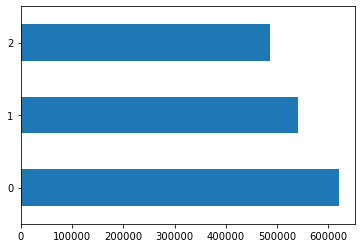

In [6]:
data_test.loc[:,'MLQF_true'].value_counts().plot(kind='barh')

In [7]:
# fit regressor
M.fit(X_train, y_train)
preds = M.predict(X_test)

data_test['MLQF'] = preds
print(data_test['MLQF'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.5s


12374       0
12416       0
12375       0
12439       2
12443       0
           ..
54034513    2
54034505    2
54034538    0
54048073    2
54048249    2
Name: MLQF, Length: 1648155, dtype: int64


[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.6s finished


<AxesSubplot:>

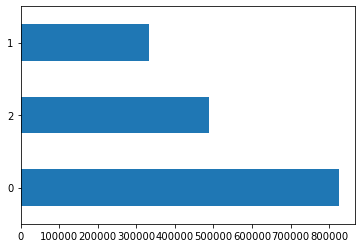

In [8]:
data_test.loc[:,'MLQF'].value_counts().plot(kind='barh')

In [9]:
data_mlqf0 = data_test[(data_test['MLQF'] == 0)]
data_mlqf1 = data_test[(data_test['MLQF'] == 1)]
data_mlqf = pd.concat([data_mlqf0,data_mlqf1])
print(get_RMSE(data_mlqf0['xco2raw_SA_bias']))
print(get_RMSE(data_mlqf1['xco2raw_SA_bias']))
print(get_RMSE(data_mlqf['xco2raw_SA_bias']))
# print(data_mlqf['xco2tccon'].std())
precision, recall, fscore, support = precision_recall_fscore_support(data_test['MLQF'], data_test['MLQF_true'])

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

print(len(data_mlqf0)/len(data_test) * 100)
print(len(data_mlqf1)/len(data_test) * 100)
print(len(data_mlqf)/len(data_test) * 100)

0.8740160311300825
0.8497240353440627
0.867122385374534
precision: [0.5892339  0.24640519 0.47054059]
recall: [0.44300747 0.40091053 0.46752244]
fscore: [0.50576353 0.30521871 0.46902666]
support: [826503 332114 489538]
50.14716455673162
20.150653306272773
70.29781786300438


TCCON Stations :  ['' 'bremen01' 'burgos01' 'easttroutlake01' 'izana01' 'jpl02'
 'karlsruhe01' 'lamont01' 'lauder02' 'lauder03' 'nicosia01' 'nyalesund01'
 'orleans01' 'paris01' 'parkfalls01' 'reunion01' 'rikubetsu01' 'saga01'
 'sodankyla01' 'tsukuba02']

ML correction to tccon
STD: XCO2 corrected - XCO2 tccon: 1.1833910480268661
median: XCO2 corrected - XCO2 tccon: -0.06470679538836066

B11 to tccon
STD: XCO2bc - XCO2 tccon: 1.2366272594251164
median: XCO2bc - XCO2 tccon: 0.056427001953125

Raw to tccon
STD: XCO2bc - XCO2 tccon: 1.5606644580817064
median: XCO2bc - XCO2 tccon: 0.3614501953125


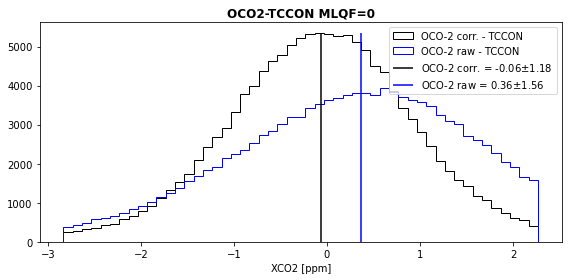

ML-TCCON RMSE QF = 0 :  1.1871740831911095


In [10]:
TCCON_names = np.unique(data_train['tccon_name'].to_numpy())
TCCON_names = TCCON_names[TCCON_names != 'pasadena01']
TCCON_names = TCCON_names[TCCON_names != 'xianghe01']
print('TCCON Stations : ', TCCON_names)

xco2ML_std, xco2ML_mean, xco2B11_std, xco2B11_mean, xco2raw_std, xco2raw_mean, xco2ML_RMSE_QF0, xco2B11_RMSE, xco2raw_RMSE = plot_tccon(data_mlqf0,
                                                                                               TCCON_names,
                                                                                               save_fig=None,
                                                                                               path=None,
                                                                                               name=None)

print('ML-TCCON RMSE QF = 0 : ', xco2ML_RMSE_QF0)

TCCON Stations :  ['' 'bremen01' 'burgos01' 'easttroutlake01' 'izana01' 'jpl02'
 'karlsruhe01' 'lamont01' 'lauder02' 'lauder03' 'nicosia01' 'nyalesund01'
 'orleans01' 'paris01' 'parkfalls01' 'reunion01' 'rikubetsu01' 'saga01'
 'sodankyla01' 'tsukuba02']

ML correction to tccon
STD: XCO2 corrected - XCO2 tccon: 1.195247857363229
median: XCO2 corrected - XCO2 tccon: -0.07315129491212247

B11 to tccon
STD: XCO2bc - XCO2 tccon: 1.2541839244443005
median: XCO2bc - XCO2 tccon: 0.050201416015625

Raw to tccon
STD: XCO2bc - XCO2 tccon: 1.5717826537099222
median: XCO2bc - XCO2 tccon: 0.347442626953125


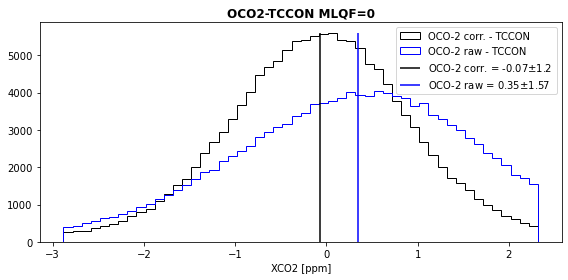

ML-TCCON RMSE QF = 1 :  1.1997618882116232


In [11]:
TCCON_names = np.unique(data_train['tccon_name'].to_numpy())
TCCON_names = TCCON_names[TCCON_names != 'pasadena01']
TCCON_names = TCCON_names[TCCON_names != 'xianghe01']
print('TCCON Stations : ', TCCON_names)

xco2ML_std, xco2ML_mean, xco2B11_std, xco2B11_mean, xco2raw_std, xco2raw_mean, xco2ML_RMSE_QF0, xco2B11_RMSE, xco2raw_RMSE = plot_tccon(data_mlqf,
                                                                                               TCCON_names,
                                                                                               save_fig=None,
                                                                                               path=None,
                                                                                               name=None)

print('ML-TCCON RMSE QF = 1 : ', xco2ML_RMSE_QF0)

/Users/williamkeely/Desktop/B11/OCO_Bias_Filt/util.py:841: RuntimeWarning: divide by zero encountered in true_divide
  result = (result1 - result2) /result2 * 100


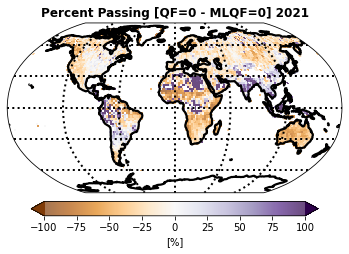

In [12]:
plot_qf_map(data_qf, data_mlqf0, None,year = '2021', save_fig=False, path='None', name='None',diff = True, statistic = 'mean')

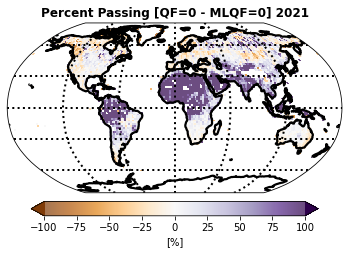

In [13]:
plot_qf_map(data_qf, data_mlqf, None,year = '2021', save_fig=False, path='None', name='None',diff = True, statistic = 'mean')

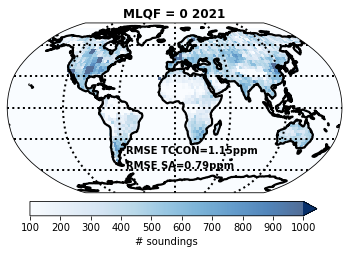

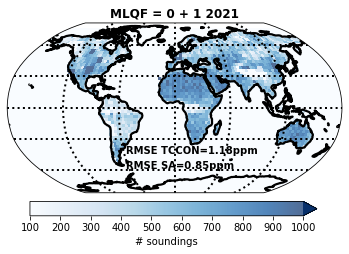

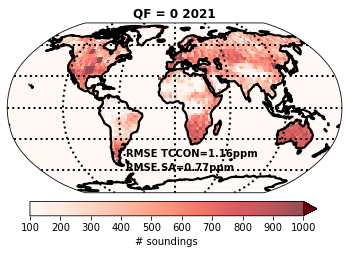

In [315]:
import cartopy.crs as ccrs
# plt.rcParams["figure.figsize"] = (10,7)


result, xedges, yedges = np.histogram2d(data_mlqf0['longitude'],data_mlqf0['latitude'],bins=[120, 60])
result = result.clip(1)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1,
                         projection=ccrs.Robinson())
ax.coastlines(color = 'black', linewidth = 2.2)
ax.gridlines(linestyle='dotted', linewidth = 2, color = 'black')
fig.text(x = 0.40,y=0.34, s = 'RMSE TCCON=1.15ppm', fontsize = 10, weight = 'bold')
fig.text(x = 0.40,y=0.29, s = 'RMSE SA=0.79ppm', fontsize = 10, weight = 'bold')

im = ax.imshow(result.T, interpolation='nearest', origin='lower',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Blues',vmin = 100, vmax = 1000, transform=ccrs.PlateCarree(), alpha = 0.7)

ax.set_title("MLQF = 0 2021", fontweight = 'bold')
plt.colorbar(im, fraction=0.066, pad=0.04, extend='max', location = 'bottom', label='# soundings')
plt.savefig('mlqf_tern_0.png', dpi = 200)
plt.show()

result, xedges, yedges = np.histogram2d(data_mlqf['longitude'],data_mlqf['latitude'],bins=[120, 60])
result = result.clip(1)
fig = plt.figure()
fig.text(x = 0.40,y=0.34, s = 'RMSE TCCON=1.18ppm', fontsize = 10, weight = 'bold')
fig.text(x = 0.40,y=0.29, s = 'RMSE SA=0.85ppm', fontsize = 10, weight = 'bold')
ax = fig.add_subplot(1, 1, 1,
                         projection=ccrs.Robinson())
ax.coastlines(color = 'black', linewidth = 2.2)
ax.gridlines(linestyle='dotted', linewidth = 2, color = 'black')
im = ax.imshow(result.T, interpolation='nearest', origin='lower',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Blues',vmin = 100, vmax = 1000, transform=ccrs.PlateCarree(), alpha = 0.7)

ax.set_title("MLQF = 0 + 1 2021", fontweight = 'bold')
plt.colorbar(im, fraction=0.066, pad=0.04, extend='max', location = 'bottom', label='# soundings')
plt.savefig('mlqf_tern_1.png', dpi = 200)
plt.show()


result, xedges, yedges = np.histogram2d(data_qf['longitude'],data_qf['latitude'],bins=[120, 60])
result = result.clip(1)
fig = plt.figure()
fig.text(x = 0.40,y=0.33, s = 'RMSE TCCON=1.16ppm', fontsize = 10, weight = 'bold')
fig.text(x = 0.40,y=0.28, s = 'RMSE SA=0.77ppm', fontsize = 10, weight = 'bold')
ax = fig.add_subplot(1, 1, 1,
                         projection=ccrs.Robinson())
ax.coastlines(color = 'black', linewidth = 2.2)
ax.gridlines(linestyle='dotted', linewidth = 2, color = 'black')
im = ax.imshow(result.T, interpolation='nearest', origin='lower',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Reds',vmin = 100, vmax = 1000, transform=ccrs.PlateCarree(), alpha = 0.7)

ax.set_title("QF = 0 2021", fontweight = 'bold')
plt.colorbar(im, fraction=0.066, pad=0.04, extend='max', location = 'bottom', label='# soundings')
plt.show()

In [278]:
# TODO Get prec, recall, f1 for MLQF = 0 + 1 v. MLQF = 2
# TODO Make plots state vars. Are distributions highly un-physical?

<h2>Ternary Flag (with Spatial Weighting)</h2>

In [ ]:
def balance_sounding_loc(data):
    ''' calculates weights for elements of data depending on density of soundings for a given location

    :param data: DataFrame
    :return: ndarray; of weights that can be used to subsample data
    '''
    print('calculating weights to balance soundings ...')
    # raster data
    res = 2
    Lat = data['latitude'].to_numpy()
    Lon = data['longitude'].to_numpy()
    weights = np.zeros((len(data)))

    for i in tqdm(range(len(np.arange(-90, 90, res)))):
        Lat_i = np.arange(-90, 90, res)[i]
        for Lon_i in range(-180, 180, res):
            # check if we have measurements in bin
            match = (Lat >= Lat_i) & (Lat < Lat_i + res) & (Lon >= Lon_i) & (Lon < Lon_i + res)
            bin = np.sum(match)
            if bin > 0:
                weights[match] = 1/bin
            else:
                weights[match] = 0

    return weights

In [ ]:
tcconRidgeDirString = '/Users/williamkeely/Desktop/B11/current/bias_models_current/current/V4_5_nofoot_noTCsplit_dws_xco2_TCCON_biasall_all_RF0/'  # path to 1st bias model directory
rfDirString = '/Users/williamkeely/Desktop/B11/current/bias_models_current/current/V4_5_precRF_noTC_nofoot_noTCsplit_xco2raw_SA_biasall_all_RF0/'  # path to 2nd bias model directory
qfModelDirString = '/Users/williamkeely/Desktop/B11/current/MLQF_models'

train_years = [2018,2019,2020,2022]

data_train = generate_training_set(train_years=train_years,tccon_flag = False,mode='all',qf=None,preload_IO=True,footprint=0,Steffen_IO=False)
data_test = load_data(2021, 'all', verbose_IO=True, qf=None, preload_IO=True, footprint=0, Steffen_IO=False)

# set land fraction 0 = land, 1 = ocean
data_train = data_train[data_train['land_water_indicator'] == 0]
data_test = data_test[data_test['land_water_indicator'] == 0]

data_qf = data_test.copy(deep=True) # deep copy for plotting
data_qf = data_qf[data_qf['xco2_quality_flag'] == 0] # use to evaluate difference between MLQF and B11 QF
data_train['xco2_ret'] = data_train['xco2_raw']    
data_test['xco2_ret'] = data_test['xco2_raw']    
# make bias correction 1
vars = ['xco2_raw']
data_train = bias_correct(tcconRidgeDirString, data_train, vars)
data_test = bias_correct(tcconRidgeDirString, data_test, vars)

# make bias correction 2 # if we have a two step bias corr model
data_train = bias_correct(rfDirString, data_train, vars)
data_test = bias_correct(rfDirString, data_test, vars)

data_train['xco2MLcorr'] =  data_train['xco2_raw']
data_test['xco2MLcorr'] = data_test['xco2_raw'] 

# recalculate small area bias
data_test.sort_values('SA', inplace=True)
XCO2 = data_test.loc[:, 'xco2MLcorr'].to_numpy()
SA = data_test.loc[:, 'SA'].to_numpy()
data_test.loc[:, 'xco2raw_SA_bias'] = calc_SA_bias(XCO2, SA)

In [ ]:
weights = balance_sounding_loc(data_train)

In [ ]:
weights

# switch weighting schema and use abs(diffxco2) weighting + sounding density

In [ ]:
# land vars
feats = ['co2_grad_del','dpfrac','aod_strataer','dp_o2a','h_continuum_sco2','aod_ice','ice_height','h_continuum_o2a','aod_sulfate','co2_ratio','albedo_sco2', 'rms_rel_wco2',
                   'rms_rel_sco2','footprint','solar_zenith_angle']


# create a list of our conditions
thresholds_train = [
    (np.abs(data_train['xco2raw_SA_bias']) > 0.9),
    (np.abs(data_train['xco2raw_SA_bias']) >= 0.27) & (np.abs(data_train['xco2raw_SA_bias']) <= 0.9) & (data_train['xco2tccon'].isna()),
    ((np.abs(data_train['xco2MLcorr'] - data_train['xco2tccon']) <= 1.15) & (data_train['xco2tccon'].notna())) | (np.abs(data_train['xco2raw_SA_bias']) <= 0.27)

    
    ]
thresholds_test = [
    
    (np.abs(data_test['xco2raw_SA_bias']) > 0.9),
    (np.abs(data_test['xco2raw_SA_bias']) >= 0.27) & (np.abs(data_test['xco2raw_SA_bias']) <= 0.9) & (data_test['xco2tccon'].isna()),
    ((np.abs(data_test['xco2MLcorr'] - data_test['xco2tccon']) <= 1.15)& (data_test['xco2tccon'].notna())) | (np.abs(data_test['xco2raw_SA_bias']) <= 0.27)


    ]

# create a list of the values we want to assign for each condition
flags = [2,1,0]

# create a new column and use np.select to assign values to it using our lists as arguments
data_train['MLQF_true'] = np.select(thresholds_train, flags)
data_test['MLQF_true'] = np.select(thresholds_test,flags)



data_train = data_train.dropna(subset=['MLQF_true'])
data_test = data_test.dropna(subset=['MLQF_true'])

y_train = data_train['MLQF_true']
y_test = data_test['MLQF_true']

y_test.isnull().sum()

X_train = data_train[feats]
X_test = data_test[feats]



M = RandomForestClassifier(n_estimators=100,
                                   max_depth=12,
                                   max_samples=len(X_train)//2,
                                   min_samples_split=40,
                                   min_samples_leaf=10,
                                   min_weight_fraction_leaf=0.0,
                                   max_features='sqrt',
                                   max_leaf_nodes=None,
                                   min_impurity_decrease=0.0,
                                   bootstrap=True,
                                   oob_score=False,
                                   n_jobs=-1,
                                   random_state=None,
                                   verbose=1,
                                   warm_start=False,
                           
                         class_weight = {0 : 4.0, 1 : 2.3, 2 : 1.0}
                          )

In [ ]:
# fit regressor
M.fit(X_train, y_train, sample_weight = weights)
preds = M.predict(X_test)

data_test['MLQF'] = preds
print(data_test['MLQF'])

In [ ]:
data_test.loc[:,'MLQF_true'].value_counts().plot(kind='barh')

In [ ]:
data_test.loc[:,'MLQF'].value_counts().plot(kind='barh')

In [ ]:
data_mlqf0 = data_test[(data_test['MLQF'] == 0)]
data_mlqf1 = data_test[(data_test['MLQF'] == 1)]
data_mlqf = pd.concat([data_mlqf0,data_mlqf1])
print(get_RMSE(data_mlqf0['xco2raw_SA_bias']))
print(get_RMSE(data_mlqf1['xco2raw_SA_bias']))
print(get_RMSE(data_mlqf['xco2raw_SA_bias']))
# print(data_mlqf['xco2tccon'].std())
precision, recall, fscore, support = precision_recall_fscore_support(data_test['MLQF'], data_test['MLQF_true'])

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

print(len(data_mlqf0)/len(data_test) * 100)
print(len(data_mlqf1)/len(data_test) * 100)
print(len(data_mlqf)/len(data_test) * 100)

In [ ]:
TCCON_names = np.unique(data_train['tccon_name'].to_numpy())
TCCON_names = TCCON_names[TCCON_names != 'pasadena01']
TCCON_names = TCCON_names[TCCON_names != 'xianghe01']
print('TCCON Stations : ', TCCON_names)

xco2ML_std, xco2ML_mean, xco2B11_std, xco2B11_mean, xco2raw_std, xco2raw_mean, xco2ML_RMSE_QF0, xco2B11_RMSE, xco2raw_RMSE = plot_tccon(data_mlqf0,
                                                                                               TCCON_names,
                                                                                               save_fig=None,
                                                                                               path=None,
                                                                                               name=None)

print('ML-TCCON RMSE QF = 0 : ', xco2ML_RMSE_QF0)

In [ ]:
plot_qf_map(data_qf, data_mlqf, None,year = '2021', save_fig=False, path='None', name='None',diff = True, statistic = 'mean')

<h2> O'Dell QF Precision/Recall Thresh = 1.0 ppm</h2>

In [ ]:
tcconRidgeDirString = '/Users/williamkeely/Desktop/B11/current/bias_models_current/current/V4_5_nofoot_noTCsplit_dws_xco2_TCCON_biasall_all_RF0/'  # path to 1st bias model directory
rfDirString = '/Users/williamkeely/Desktop/B11/current/bias_models_current/current/V4_5_precRF_noTC_nofoot_noTCsplit_xco2raw_SA_biasall_all_RF0/'  # path to 2nd bias model directory
qfModelDirString = '/Users/williamkeely/Desktop/B11/current/MLQF_models'

train_years = [2018,2019,2020,2022]

data_train = generate_training_set(train_years=train_years,tccon_flag = False,mode='all',qf=None,preload_IO=True,footprint=0,Steffen_IO=False)
data_test = load_data(2021, 'all', verbose_IO=True, qf=None, preload_IO=True, footprint=0, Steffen_IO=False)

# set land fraction 0 = land, 1 = ocean
data_train = data_train[data_train['land_water_indicator'] == 0]
data_test = data_test[data_test['land_water_indicator'] == 0]


# data_qf = data_qf[data_qf['xco2_quality_flag'] == 0] # use to evaluate difference between MLQF and B11 QF
data_train['xco2_ret'] = data_train['xco2_raw']    
data_test['xco2_ret'] = data_test['xco2_raw']    
# make bias correction 1
vars = ['xco2_raw']
data_train = bias_correct(tcconRidgeDirString, data_train, vars)
data_test = bias_correct(tcconRidgeDirString, data_test, vars)

# make bias correction 2 # if we have a two step bias corr model
data_train = bias_correct(rfDirString, data_train, vars)
data_test = bias_correct(rfDirString, data_test, vars)

data_train['xco2MLcorr'] =  data_train['xco2_raw']
data_test['xco2MLcorr'] = data_test['xco2_raw'] 



# recalculate small area bias
data_test.sort_values('SA', inplace=True)
XCO2 = data_test.loc[:, 'xco2MLcorr'].to_numpy()
SA = data_test.loc[:, 'SA'].to_numpy()
data_test.loc[:, 'xco2raw_SA_bias'] = calc_SA_bias(XCO2, SA)

data_qf = data_test.copy(deep=True) # deep copy for plotting

In [ ]:
data_qf['QF_true'] = pd.cut(np.abs(data_qf['xco2raw_SA_bias']), bins = [0.0,1.0,np.abs(data_qf['xco2raw_SA_bias']).max()], labels = [0,1], right=False)

In [ ]:
data_qf0_true = data_qf[(data_qf['QF_true'] == 0)]
data_qf0 = data_qf[(data_qf['xco2_quality_flag'] == 0)]

data_qf = data_qf.dropna(subset=['QF_true'])

print(get_RMSE(data_qf0_true['xco2raw_SA_bias']))
print(get_RMSE(data_qf0['xco2raw_SA_bias']))
# print(data_mlqf['xco2tccon'].std())
precision, recall, fscore, support = precision_recall_fscore_support(data_qf['xco2_quality_flag'], data_qf['QF_true'])

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

print(len(data_qf0_true)/len(data_test) * 100)
print(len(data_qf0)/len(data_test) * 100)


In [ ]:
# from tqdm import tqdm
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from matplotlib.ticker import NullFormatter
# from sklearn import manifold
# from sklearn.neighbors import KDTree
# from util import load_data, plot_map, feature_selector
# import collections

# # make changes #############################
# name = '_'
# save_fig = True    # save figures to hard drive
# qf = None
# path = '/Users/wiulliamkeely/Desktop/B11/Data/'
# mode = 'all'
# preload_IO = True
# #stop make changes ###########################


# years = [2018,2019,2020,2021,2022]
# import warnings
# with warnings.catch_warnings():
#     warnings.simplefilter(action='ignore', category=FutureWarning)
#     pd.options.mode.chained_assignment = None
#     # Warning-causing lines of code here
#     for year in years:
#         # load data
#         data = load_data(year, mode, qf=qf, Steffen_IO=False)


#         feature_select = 'TCCON_bias_all'
#         # get features
#         features, feature_n = feature_selector(feature_select)
#         features = ['co2_grad_del','dpfrac']
#         #****************************************************************
#         data.sort_values('SA', inplace=True)

#         X = data[features].copy()
#         X_mean = X.mean()
#         X_std = X.std()
#         X = (X - X_mean) / X_std

#         # get TCCON station names
#         TC_data = X.loc[(data['xco2tccon'].to_numpy() > 0) & (data['tccon_name'] != 'pasadena01') & (data['tccon_name'] != 'xianghe01'),:].sample(10**4, replace=False)
#         #TC_data = X.loc[(data['xco2tccon'].to_numpy() > 0),:].sample(10**4, replace=False)
#         OCO = pd.isna(data['xco2tccon']).to_numpy()

#         #****************************************************************
#         ## Perform t-distributed stochastic neighbor embedding.
#         # tsne = manifold.TSNE(n_components=2, random_state=0, n_jobs=8, perplexity=100, n_iter=2000)
#         # trans_data = tsne.fit_transform(X)
#         #
#         # plt.figure()
#         # plt.scatter(trans_data[OCO,0], trans_data[OCO,1], c='g', s=1)
#         # plt.scatter(trans_data[TC,0], trans_data[TC,1], c='r', s=3)
#         # plt.title("t-SNE OCO-2")
#         # plt.show()
#         #****************************************************************

#         # calculate distance of individual Sounding to nearest TCCON soundings in feature space
#         print('fit tree')
#         kdt = KDTree(TC_data, leaf_size=50, metric='euclidean')


#         print('calc distances')
#         distances, _ = kdt.query(X, k=10, sort_results=False, dualtree=True)
#         mean_dist = np.mean(distances, axis=1)
#         data['TCCON_dist'] = mean_dist

#         # print('make plots')
#         # # plot distribution
#         # plt.figure(figsize=(4, 3))
#         # bins = np.linspace(0, 5, 100)
#         # plt.hist(mean_dist, bins=bins, histtype='step', color='b')
#         # plt.title(name)
#         # plt.xlabel('Distance to TCCON in feature space')
#         # plt.legend()
#         # plt.tight_layout()
#         # if save_fig:
#         #     plt.savefig(path + name + 'Sounding_id_dist' + '.png', dpi=300)
#         # else:
#         #     plt.show()
#         # plt.close()
#         #
#         # # plot mean distance on map
#         # data['TCCON_dist'] = mean_dist
#         # plot_map(data, ['TCCON_dist'], save_fig=save_fig, path=path, name=name + '_iD_Distance', pos_neg_IO=False)

#         #****************************************************************
#         # calculate distance of SA median soundings to nearest TCCON soundings in feature space
#         SA_unique = list(pd.unique(data['SA']))
#         SA = data['SA'].to_numpy()

#         X_meds = []
#         idx_SAs = []

#         assert SA[0] <= SA[-1], 'SA needs to be sorted'
#         print('get idx for SAs')
#         result = collections.defaultdict(list)
#         for i in tqdm(range(len(SA))):
#             SA_i = SA[i]
#             result[SA_i].append(i)

#         # print('calc median feature for SAs')
#         # for i in tqdm(range(len(SA_unique))):
#         #     a = SA_unique[i]
#         #     idx_SA = result[a]
#         #     X_meds.append(X.iloc[idx_SA].median().to_frame().T)

#         # print('calc SA distances to TCCON')
#         # X_meds = pd.concat(X_meds, ignore_index=True)
#         # distances, _ = kdt.query(X_meds, k=10, dualtree=True)
#         # mean_dists = np.mean(distances, axis=1)

#         print('Merge results with DataFrame')
#         data['TCCON_dist_SA'] = np.zeros_like(SA) * np.nan
#         for i in tqdm(range(len(SA_unique))):
#             a = SA_unique[i]
#             idx_SA = result[a]
#             data['TCCON_dist_SA'].iloc[idx_SA] = data['TCCON_dist'].iloc[idx_SA].median()

#         print('make plots')
#         # plot mean distance on map
#         # plot_map(data, ['TCCON_dist','TCCON_dist_SA' ], save_fig=save_fig, path=path, name=name +str(year)+ '_SA_Distance', pos_neg_IO=False)
#         # for i in np.arange(0.1, 1.0, 0.1):
#         #     t = data['TCCON_dist'].quantile(i)
#         #     plot_map(data.loc[data['TCCON_dist'] < t,:], ['TCCON_dist'], save_fig=save_fig, path=path,
#         #              name=name + '_SAmed_Distance' + str(np.round(i,1)), min = 0, max = 2,pos_neg_IO=False)
#         #     plot_map(data.loc[data['TCCON_dist'] < t, :], ['TCCON_dist'], save_fig=save_fig, path=path,
#         #              name=name + '_count_' + str(np.round(i, 1)), min=0, aggregate='count', pos_neg_IO=False)

#         # save everything
#         data.to_parquet('/Users/williamkeely/Desktop/B11/Data/PreLoadB11_5M_balanced_all_TCdist_qfNone_' +str(year)+ '.parquet')
        

#     print('Done >>>')

In [ ]:
df_2022 = load_data(2022, mode='all', qf=None, Steffen_IO = False)

In [ ]:
df_2022['xco2tccon'].isna().sum()

<h2>Binary MLQF with feature space distance (SA - TCCON)</h2>

In [ ]:
# tcconRidgeDirString = '/Users/williamkeely/Desktop/B11/current/bias_models_current/current/V4_5_nofoot_noTCsplit_dws_xco2_TCCON_biasall_all_RF0/'  # path to 1st bias model directory
# rfDirString = '/Users/williamkeely/Desktop/B11/current/bias_models_current/current/V4_5_precRF_noTC_nofoot_noTCsplit_xco2raw_SA_biasall_all_RF0/'  # path to 2nd bias model directory
tcconRidgeDirString = '/Users/williamkeely/Desktop/B11/current/bias_models_current/region_specific_NDGL/V3_7_nofoot_noTCsplit_xco2_TCCON_biasLndNDGL_lnd_Ransac0/'  # path to 1st bias model directory
rfDirString = '/Users/williamkeely/Desktop/B11/current/bias_models_current/region_specific_NDGL/V3_7_precRansac_nofoot_noTCsplit_xco2raw_SA_biasLndNDGL_lnd_RF0/'  # path to 2nd bias model directory
qfModelDirString = '/Users/williamkeely/Desktop/B11/current/MLQF_models'

train_years = [2018,2019,2020]

data_train = generate_training_set(train_years=train_years,tccon_flag = False,mode='all',qf=None,preload_IO=True,footprint=0,Steffen_IO=False)
data_test = load_data(2021, 'all', verbose_IO=True, qf=None, preload_IO=True, footprint=0, Steffen_IO=False)

# set land fraction 0 = land, 1 = ocean
data_train = data_train[data_train['land_water_indicator'] == 0]
data_test = data_test[data_test['land_water_indicator'] == 0]

data_train['xco2_ret'] = data_train['xco2_raw']    
data_test['xco2_ret'] = data_test['xco2_raw'] 

data_qf = data_test.copy(deep=True) # deep copy for plotting
data_qf = data_qf[data_qf['xco2_quality_flag'] == 0] # use to evaluate difference between MLQF and B11 QF
   
# make bias correction 1
vars = ['xco2_raw']
data_train = bias_correct(tcconRidgeDirString, data_train, vars)
data_test = bias_correct(tcconRidgeDirString, data_test, vars)

# make bias correction 2 # if we have a two step bias corr model
data_train = bias_correct(rfDirString, data_train, vars)
data_test = bias_correct(rfDirString, data_test, vars)

data_train['xco2MLcorr'] =  data_train['xco2_raw']
data_test['xco2MLcorr'] = data_test['xco2_raw'] 

# recalculate small area bias
data_test.sort_values('SA', inplace=True)
XCO2 = data_test.loc[:, 'xco2MLcorr'].to_numpy()
SA = data_test.loc[:, 'SA'].to_numpy()
data_test.loc[:, 'xco2raw_SA_bias'] = calc_SA_bias(XCO2, SA)

loading data from 2018...
loading data from 2019...
loading data from 2020...


In [ ]:
data_train['TCCON_dist_SA'] = data_train['TCCON_dist_SA'] * 100
data_train['TCCON_dist_SA'].describe()

In [ ]:
data_train['TCCON_dist_SA']

In [ ]:
# land vars
feats = ['co2_grad_del','dpfrac','aod_strataer','dp_o2a','h_continuum_sco2','aod_ice','ice_height','h_continuum_o2a','aod_sulfate','co2_ratio','albedo_sco2', 'rms_rel_wco2',
                   'rms_rel_sco2','footprint','solar_zenith_angle']


# create a list of our conditions
thresholds_train = [
    ((np.abs(data_train['xco2raw_SA_bias']) > 0.9) | ((np.abs(data_train['xco2raw_SA_bias']) <= 0.9) & (np.abs(data_train['TCCON_dist_SA']) > 6.032))),
    ((np.abs(data_train['xco2raw_SA_bias']) <= 0.9) & (np.abs(data_train['TCCON_dist_SA']) <= 6.032 ))

    
    ]
thresholds_test = [
    ((np.abs(data_test['xco2raw_SA_bias']) > 0.9) | ((np.abs(data_test['xco2raw_SA_bias']) <= 0.9) & (np.abs(data_test['TCCON_dist_SA']) > 6.032 ))),
    ((np.abs(data_test['xco2raw_SA_bias']) <= 0.9) & (np.abs(data_test['TCCON_dist_SA']) <= 6.032 ))

# + 5.184
    ]

# create a list of the values we want to assign for each condition
flags = [1,0]

# create a new column and use np.select to assign values to it using our lists as arguments
data_train['MLQF_true'] = np.select(thresholds_train, flags)
data_test['MLQF_true'] = np.select(thresholds_test,flags)



data_train = data_train.dropna(subset=['MLQF_true'])
data_test = data_test.dropna(subset=['MLQF_true'])

y_train = data_train['MLQF_true']
y_test = data_test['MLQF_true']

y_test.isnull().sum()

X_train = data_train[feats]
X_test = data_test[feats]



M = RandomForestClassifier(n_estimators=100,
                                   max_depth=12,
                                   max_samples=len(X_train)//2,
                                   min_samples_split=40,
                                   min_samples_leaf=10,
                                   min_weight_fraction_leaf=0.0,
                                   max_features='sqrt',
                                   max_leaf_nodes=None,
                                   min_impurity_decrease=0.0,
                                   bootstrap=True,
                                   oob_score=False,
                                   n_jobs=-1,
                                   random_state=None,
                                   verbose=1,
                                   warm_start=False,
                         class_weight = {0 : 3.0, 1 : 1.0}
                           #class_weight = {0 : 3.0, 1 : 1.5, 2 : 2.1}
                          )

In [ ]:
data_test.loc[:,'MLQF_true'].value_counts().plot(kind='barh')

In [ ]:
# fit regressor
M.fit(X_train, y_train)
preds = M.predict(X_test)

data_test['MLQF'] = preds
print(data_test['MLQF'])

In [ ]:
data_test.loc[:,'MLQF'].value_counts().plot(kind='barh')

In [ ]:
data_mlqf0 = data_test[(data_test['MLQF'] == 0)]
data_mlqf1 = data_test[(data_test['MLQF'] == 1)]
#data_mlqf = pd.concat([data_mlqf0,data_mlqf1])
print(get_RMSE(data_mlqf0['xco2raw_SA_bias']))
print(get_RMSE(data_mlqf1['xco2raw_SA_bias']))
#print(get_RMSE(data_mlqf['xco2raw_SA_bias']))
# print(data_mlqf['xco2tccon'].std())
precision, recall, fscore, support = precision_recall_fscore_support(data_test['MLQF'], data_test['MLQF_true'])

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

print(len(data_mlqf0)/len(data_test) * 100)
print(len(data_mlqf1)/len(data_test) * 100)
#print(len(data_mlqf)/len(data_test) * 100)

In [ ]:
pd.options.display.max_columns = None
data_test.head()

In [ ]:
plt.figure(figsize=(8, 4))
dataml = data_mlqf0[data_mlqf0['xco2tccon'] > 0]
dataqf = data_qf[data_qf['xco2tccon'] > 0]

diff_ML = data_mlqf0['xco2raw_SA_bias']
# diff_B11 = data_qf['xco2'] - data_qf['xco2tccon']
diff_raw = data_mlqf0['xco2_SA_bias'] 

xco2ML_median = np.median(diff_ML)
# xco2B11_median = np.median(diff_B11)
xco2raw_median = np.median(diff_raw)


bins = np.arange(np.percentile(diff_ML, 2), np.percentile(diff_ML, 98), 0.1)

n = plt.hist(diff_ML, bins=bins, label='OCO-2 corr. - SA', histtype='step', color='k')
# plt.hist(diff_ML, bins=bins, label='OCO-2 corr. - TCCON', histtype='step', color = 'k') # work around for MLQF plotting error.
# plt.hist(diff_B11, bins=bins, label='OCO-2 B11 - TCCON QF=0', histtype='step', color='r')
plt.hist(diff_raw, bins=bins, label='OCO-2 raw - TCCON', histtype='step', color='b')
plt.vlines(xco2ML_median, 0, np.max(n[0]), colors='k',
               label='OCO-2 corr. = ' + str(np.round(xco2ML_median, 2)) + r'$\pm$' + str(np.round(np.std(diff_ML), 2)))
# plt.vlines(xco2B11_median, 0, np.max(n[0]), colors='r',
#                label='OCO-2 B11 = ' + str(np.round(xco2B11_median, 2)) + r'$\pm$' + str(
#                    np.round(np.std(diff_B11), 2)))
plt.vlines(xco2raw_median, 0, np.max(n[0]), colors='b',
               label='OCO-2 raw = ' + str(np.round(xco2raw_median, 2)) + r'$\pm$' + str(
                   np.round(np.std(diff_raw), 2)))

plt.title('OCO-2 - SA MLQF=0', fontweight = 'bold')
plt.xlabel('XCO2 [ppm]')
plt.legend()
plt.tight_layout()
plt.savefig('SA_hist_max_pass.png',dpi=200)

In [ ]:
TCCON_names = data_test['tccon_name'].unique()
holdout_set = ['parkfalls01','lamont01','saga01','tsukuba02','burgos01']
TCCON_names = TCCON_names[TCCON_names != 'pasadena01']
TCCON_names = TCCON_names[TCCON_names != 'xianghe01']
# TCCON_names = TCCON_names[np.isin(TCCON_names,holdout_set)]
print('TCCON Stations : ', TCCON_names)

xco2ML_std, xco2ML_mean, xco2B11_std, xco2B11_mean, xco2raw_std, xco2raw_mean, xco2ML_RMSE_QF0, xco2B11_RMSE, xco2raw_RMSE = plot_tccon(data_mlqf0,
                                                                                               TCCON_names,
                                                                                               save_fig=True,
                                                                                               path='/Users/williamkeely/Desktop/',
                                                                                               name='TCCON_rmse_mlqf0_max_pass.png')

print('ML-TCCON RMSE QF = 0 : ', xco2ML_RMSE_QF0)

import cartopy.crs as ccrs
# plt.rcParams["figure.figsize"] = (10,7)


result, xedges, yedges = np.histogram2d(data_mlqf0['longitude'],data_mlqf0['latitude'],bins=[120, 60])
result = result.clip(1)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1,
                         projection=ccrs.Robinson())
ax.coastlines(color = 'black', linewidth = 2.2)
ax.gridlines(linestyle='dotted', linewidth = 2, color = 'black')
# fig.text(x = 0.40,y=0.33, s = 'RMSE TCCON=1.16ppm', fontsize = 10, weight = 'bold')
# fig.text(x = 0.40,y=0.28, s = 'RMSE SA=0.86ppm', fontsize = 10, weight = 'bold')

im = ax.imshow(result.T, interpolation='nearest', origin='lower',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Blues',vmin = 100, vmax = 1000, transform=ccrs.PlateCarree(), alpha = 0.7)

ax.set_title("MLQF = 0 2021", fontweight = 'bold')
plt.colorbar(im, fraction=0.066, pad=0.04, extend='max', location = 'bottom', label='# soundings')
plt.savefig("mlqf_binary_max_pass.png", dpi = 200)
plt.show()



result, xedges, yedges = np.histogram2d(data_qf['longitude'],data_qf['latitude'],bins=[120, 60])
result = result.clip(1)
fig = plt.figure()
# fig.text(x = 0.40,y=0.33, s = 'RMSE TCCON=1.16ppm', fontsize = 10, weight = 'bold')
# fig.text(x = 0.40,y=0.28, s = 'RMSE SA=0.77ppm', fontsize = 10, weight = 'bold')
ax = fig.add_subplot(1, 1, 1,
                         projection=ccrs.Robinson())
ax.coastlines(color = 'black', linewidth = 2.2)
ax.gridlines(linestyle='dotted', linewidth = 2, color = 'black')
im = ax.imshow(result.T, interpolation='nearest', origin='lower',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Reds',vmin = 100, vmax = 1000, transform=ccrs.PlateCarree(), alpha = 0.7)

ax.set_title("QF = 0 2021", fontweight = 'bold')
plt.colorbar(im, fraction=0.066, pad=0.04, extend='max', location = 'bottom', label='# soundings')
plt.savefig("b11_qf_0_map_reds.png", dpi = 200)
plt.show()

plot_qf_map(data_qf, data_mlqf0, None,year = '2021', save_fig=True, path='/Users/williamkeely/Desktop/', name='mlqf01_max_pass_diff',diff = True, statistic = 'mean')

In [ ]:
# xco2 diff plot
MIN = -1
MAX = 1
res = 2
deg = '\u00b0'
denominator, xedges, yedges = np.histogram2d(data_mlqf0['longitude'],data_mlqf0['latitude'],bins=[360//res, 180//res])
nominator, _, _, = np.histogram2d(data_mlqf0['longitude'],data_mlqf0['latitude'],bins=[xedges, yedges], weights=(data_mlqf0['xco2raw_SA_bias']))
result = nominator / denominator
result.clip(1)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1,
                     projection=ccrs.Robinson())
im = ax.imshow(result.T, interpolation='nearest', origin='lower',
                        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'coolwarm', vmin = -1, vmax = 1,transform=ccrs.PlateCarree())
ax.gridlines(linestyle='dotted', linewidth = 2, color = 'black')
ax.coastlines(color = 'black', linewidth = 2.2)
ax.set_title('2021 '+'\u0394' +'XCO2 [LndNDGL] 2'+deg+' x 2'+deg, fontweight = 'bold')
plt.colorbar(im, fraction=0.066, pad=0.04, extend='both', location = 'bottom', label='[ppm]')
plt.savefig('xco2_diff_max_pass_mlqf0.png', dpi = 300)
plt.show()

<h2>Binary MLQF minimize RMSE</h2>

In [44]:
# tcconRidgeDirString = '/Users/williamkeely/Desktop/B11/current/bias_models_current/current/V4_5_nofoot_noTCsplit_dws_xco2_TCCON_biasall_all_RF0/'  # path to 1st bias model directory
# rfDirString = '/Users/williamkeely/Desktop/B11/current/bias_models_current/current/V4_5_precRF_noTC_nofoot_noTCsplit_xco2raw_SA_biasall_all_RF0/'  # path to 2nd bias model directory
tcconRidgeDirString = '/Users/williamkeely/Desktop/B11/current/bias_models_current/region_specific_NDGL/V3_7_nofoot_noTCsplit_xco2_TCCON_biasLndNDGL_lnd_Ransac0/'  # path to 1st bias model directory
rfDirString = '/Users/williamkeely/Desktop/B11/current/bias_models_current/region_specific_NDGL/V3_7_precRansac_nofoot_noTCsplit_xco2raw_SA_biasLndNDGL_lnd_RF0/'  # path to 2nd bias model directory
qfModelDirString = '/Users/williamkeely/Desktop/B11/current/MLQF_models'

train_years = [2018,2019,2020]

data_train = generate_training_set(train_years=train_years,tccon_flag = False,mode='all',qf=None,preload_IO=True,footprint=0,Steffen_IO=False)
data_test = load_data(2021, 'all', verbose_IO=True, qf=None, preload_IO=True, footprint=0, Steffen_IO=False)

# set land fraction 0 = land, 1 = ocean
data_train = data_train[data_train['land_water_indicator'] == 0]
data_test = data_test[data_test['land_water_indicator'] == 0]

data_qf = data_test.copy(deep=True) # deep copy for plotting
data_qf = data_qf[data_qf['xco2_quality_flag'] == 0] # use to evaluate difference between MLQF and B11 QF
data_train['xco2_ret'] = data_train['xco2_raw']    
data_test['xco2_ret'] = data_test['xco2_raw']    
# make bias correction 1
vars = ['xco2_raw']
data_train = bias_correct(tcconRidgeDirString, data_train, vars)
data_test = bias_correct(tcconRidgeDirString, data_test, vars)

# make bias correction 2 # if we have a two step bias corr model
data_train = bias_correct(rfDirString, data_train, vars)
data_test = bias_correct(rfDirString, data_test, vars)

data_train['xco2MLcorr'] =  data_train['xco2_raw']
data_test['xco2MLcorr'] = data_test['xco2_raw'] 

# recalculate small area bias
data_test.sort_values('SA', inplace=True)
XCO2 = data_test.loc[:, 'xco2MLcorr'].to_numpy()
SA = data_test.loc[:, 'SA'].to_numpy()
data_test.loc[:, 'xco2raw_SA_bias'] = calc_SA_bias(XCO2, SA)

loading data from 2018...
loading data from 2019...
loading data from 2020...
loading data from 2021...
making predictions
making predictions
making predictions
making predictions
recalculating SA bias


In [45]:
data_train['TCCON_dist_SA'] = data_train['TCCON_dist_SA'] * 100
data_train['TCCON_dist_SA'].describe()

count    1.019659e+06
mean     6.028160e+00
std      5.105666e+00
min      1.677216e+00
25%      3.942677e+00
50%      4.699676e+00
75%      6.282086e+00
max      2.187791e+02
Name: TCCON_dist_SA, dtype: float64

In [46]:
# land vars
feats = ['co2_grad_del','dpfrac','aod_strataer','dp_o2a','h_continuum_sco2','aod_ice','ice_height','h_continuum_o2a','aod_sulfate','co2_ratio','albedo_sco2', 'rms_rel_wco2',
                   'rms_rel_sco2','footprint','solar_zenith_angle']


# create a list of our conditions
thresholds_train = [
    ((np.abs(data_train['xco2raw_SA_bias']) > 0.5) | ((np.abs(data_train['xco2raw_SA_bias']) <= 0.5) & (np.abs(data_train['TCCON_dist_SA']) > 6.032))),
    ((np.abs(data_train['xco2raw_SA_bias']) <= 0.5) & (np.abs(data_train['TCCON_dist_SA']) <= 6.032 ))

    
    ]
thresholds_test = [
    ((np.abs(data_test['xco2raw_SA_bias']) > 0.5) | ((np.abs(data_test['xco2raw_SA_bias']) <= 0.5) & (np.abs(data_test['TCCON_dist_SA']) > 6.032))),
    ((np.abs(data_test['xco2raw_SA_bias']) <= 0.5) & (np.abs(data_test['TCCON_dist_SA']) <= 6.032 ))

# + 5.184
    ]

# create a list of the values we want to assign for each condition
flags = [1,0]

# create a new column and use np.select to assign values to it using our lists as arguments
data_train['MLQF_true'] = np.select(thresholds_train, flags)
data_test['MLQF_true'] = np.select(thresholds_test,flags)



data_train = data_train.dropna(subset=['MLQF_true'])
data_test = data_test.dropna(subset=['MLQF_true'])

y_train = data_train['MLQF_true']
y_test = data_test['MLQF_true']

y_test.isnull().sum()

X_train = data_train[feats]
X_test = data_test[feats]



M = RandomForestClassifier(n_estimators=100,
                                   max_depth=12,
                                   max_samples=len(X_train)//2,
                                   min_samples_split=40,
                                   min_samples_leaf=10,
                                   min_weight_fraction_leaf=0.0,
                                   max_features='sqrt',
                                   max_leaf_nodes=None,
                                   min_impurity_decrease=0.0,
                                   bootstrap=True,
                                   oob_score=False,
                                   n_jobs=-1,
                                   random_state=None,
                                   verbose=1,
                                   warm_start=False,
                         class_weight = {0 : 3.0, 1 : 1.0}
                           #class_weight = {0 : 3.0, 1 : 1.5, 2 : 2.1}
                          )

In [47]:
# fit regressor
M.fit(X_train, y_train)
preds = M.predict(X_test)

data_test['MLQF'] = preds
print(data_test['MLQF'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.6s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.6s


12374       1
12416       1
12375       1
12439       1
12443       1
           ..
54034513    1
54034505    1
54034538    1
54048073    1
54048249    1
Name: MLQF, Length: 1648155, dtype: int64


[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.6s finished


In [48]:
data_mlqf0 = data_test[(data_test['MLQF'] == 0)]
data_mlqf1 = data_test[(data_test['MLQF'] == 1)]
#data_mlqf = pd.concat([data_mlqf0,data_mlqf1])
print(get_RMSE(data_mlqf0['xco2raw_SA_bias']))
print(get_RMSE(data_mlqf1['xco2raw_SA_bias']))
#print(get_RMSE(data_mlqf['xco2raw_SA_bias']))
# print(data_mlqf['xco2tccon'].std())
precision, recall, fscore, support = precision_recall_fscore_support(data_test['MLQF'], data_test['MLQF_true'])

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

print(len(data_mlqf0)/len(data_test) * 100)
print(len(data_mlqf1)/len(data_test) * 100)
#print(len(data_mlqf)/len(data_test) * 100)

0.6972485858306672
1.4122949846211335
precision: [0.54834754 0.66387444]
recall: [0.63635399 0.57811266]
fscore: [0.58908195 0.61803254]
support: [735006 913149]
44.59568426513283
55.40431573486717


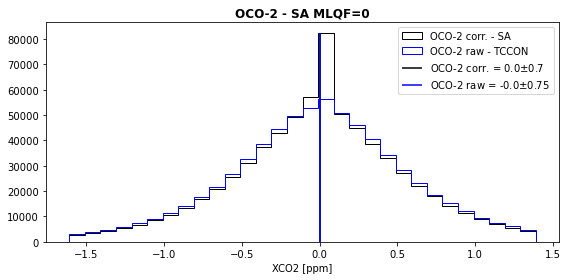

In [49]:
plt.figure(figsize=(8, 4))
dataml = data_mlqf0[data_mlqf0['xco2tccon'] > 0]
dataqf = data_qf[data_qf['xco2tccon'] > 0]

diff_ML = data_mlqf0['xco2raw_SA_bias']
# diff_B11 = data_qf['xco2'] - data_qf['xco2tccon']
diff_raw = data_mlqf0['xco2_SA_bias'] 

xco2ML_median = np.median(diff_ML)
# xco2B11_median = np.median(diff_B11)
xco2raw_median = np.median(diff_raw)


bins = np.arange(np.percentile(diff_ML, 2), np.percentile(diff_ML, 98), 0.1)

n = plt.hist(diff_ML, bins=bins, label='OCO-2 corr. - SA', histtype='step', color='k')
# plt.hist(diff_ML, bins=bins, label='OCO-2 corr. - TCCON', histtype='step', color = 'k') # work around for MLQF plotting error.
# plt.hist(diff_B11, bins=bins, label='OCO-2 B11 - TCCON QF=0', histtype='step', color='r')
plt.hist(diff_raw, bins=bins, label='OCO-2 raw - TCCON', histtype='step', color='b')
plt.vlines(xco2ML_median, 0, np.max(n[0]), colors='k',
               label='OCO-2 corr. = ' + str(np.round(xco2ML_median, 2)) + r'$\pm$' + str(np.round(np.std(diff_ML), 2)))
# plt.vlines(xco2B11_median, 0, np.max(n[0]), colors='r',
#                label='OCO-2 B11 = ' + str(np.round(xco2B11_median, 2)) + r'$\pm$' + str(
#                    np.round(np.std(diff_B11), 2)))
plt.vlines(xco2raw_median, 0, np.max(n[0]), colors='b',
               label='OCO-2 raw = ' + str(np.round(xco2raw_median, 2)) + r'$\pm$' + str(
                   np.round(np.std(diff_raw), 2)))

plt.title('OCO-2 - SA MLQF=0', fontweight = 'bold')
plt.xlabel('XCO2 [ppm]')
plt.legend()
plt.tight_layout()
plt.savefig('sa_hist_min_rmse.png', dpi = 200)

TCCON Stations :  ['' 'lauder03' 'saga01' 'lamont01' 'rikubetsu01' 'easttroutlake01'
 'nicosia01' 'izana01' 'tsukuba02' 'parkfalls01' 'paris01' 'burgos01'
 'bremen01' 'sodankyla01' 'karlsruhe01']

ML correction to tccon
STD: XCO2 corrected - XCO2 tccon: 1.1833910480268661
median: XCO2 corrected - XCO2 tccon: -0.06470679538836066

B11 to tccon
STD: XCO2bc - XCO2 tccon: 1.2366272594251164
median: XCO2bc - XCO2 tccon: 0.056427001953125

Raw to tccon
STD: XCO2bc - XCO2 tccon: 1.5606644580817064
median: XCO2bc - XCO2 tccon: 0.3614501953125
ML-TCCON RMSE QF = 0 :  1.1871740831911095


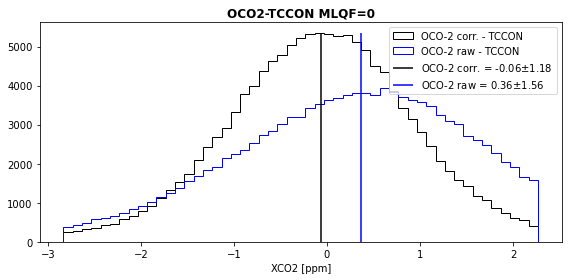

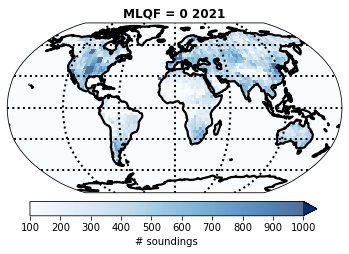

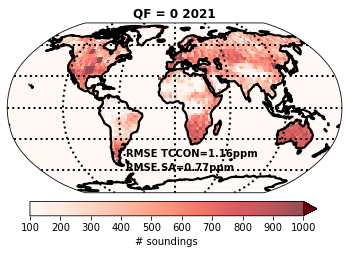

/Users/williamkeely/Desktop/B11/OCO_Bias_Filt/util.py:841: RuntimeWarning: divide by zero encountered in true_divide
  result = (result1 - result2) /result2 * 100
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.8s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


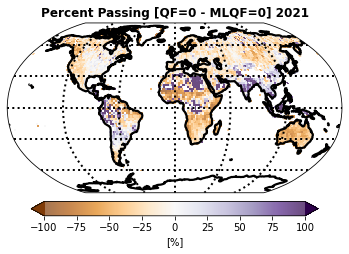

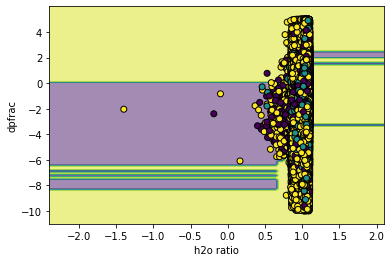

In [23]:
TCCON_names = data_test['tccon_name'].unique()
holdout_set = ['parkfalls01','lamont01','saga01','tsukuba02','burgos01']
TCCON_names = TCCON_names[TCCON_names != 'pasadena01']
TCCON_names = TCCON_names[TCCON_names != 'xianghe01']
# TCCON_names = TCCON_names[np.isin(TCCON_names,holdout_set)]
print('TCCON Stations : ', TCCON_names)

xco2ML_std, xco2ML_mean, xco2B11_std, xco2B11_mean, xco2raw_std, xco2raw_mean, xco2ML_RMSE_QF0, xco2B11_RMSE, xco2raw_RMSE = plot_tccon(data_mlqf0,
                                                                                               TCCON_names,
                                                                                               save_fig=True,
                                                                                               path='/Users/williamkeely/Desktop/',
                                                                                               name='TCCON_rmse_mlqf0_min.png')

print('ML-TCCON RMSE QF = 0 : ', xco2ML_RMSE_QF0)

import cartopy.crs as ccrs
# plt.rcParams["figure.figsize"] = (10,7)


result, xedges, yedges = np.histogram2d(data_mlqf0['longitude'],data_mlqf0['latitude'],bins=[120, 60])
result = result.clip(1)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1,
                         projection=ccrs.Robinson())
ax.coastlines(color = 'black', linewidth = 2.2)
ax.gridlines(linestyle='dotted', linewidth = 2, color = 'black')
# fig.text(x = 0.40,y=0.33, s = 'RMSE TCCON=1.08ppm', fontsize = 10, weight = 'bold')
# fig.text(x = 0.40,y=0.28, s = 'RMSE SA=0.73ppm', fontsize = 10, weight = 'bold')

im = ax.imshow(result.T, interpolation='nearest', origin='lower',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Blues',vmin = 100, vmax = 1000, transform=ccrs.PlateCarree(), alpha = 0.7)

ax.set_title("MLQF = 0 2021", fontweight = 'bold')
plt.colorbar(im, fraction=0.066, pad=0.04, extend='max', location = 'bottom', label='# soundings')
plt.savefig("mlqf_binary_min_rmse.png", dpi = 200)
plt.show()





result, xedges, yedges = np.histogram2d(data_qf['longitude'],data_qf['latitude'],bins=[120, 60])
result = result.clip(1)
fig = plt.figure()
fig.text(x = 0.40,y=0.33, s = 'RMSE TCCON=1.16ppm', fontsize = 10, weight = 'bold')
fig.text(x = 0.40,y=0.28, s = 'RMSE SA=0.77ppm', fontsize = 10, weight = 'bold')
ax = fig.add_subplot(1, 1, 1,
                         projection=ccrs.Robinson())
ax.coastlines(color = 'black', linewidth = 2.2)
ax.gridlines(linestyle='dotted', linewidth = 2, color = 'black')
im = ax.imshow(result.T, interpolation='nearest', origin='lower',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Reds',vmin = 100, vmax = 1000, transform=ccrs.PlateCarree(), alpha = 0.7)

ax.set_title("QF = 0 2021", fontweight = 'bold')
plt.colorbar(im, fraction=0.066, pad=0.04, extend='max', location = 'bottom', label='# soundings')
plt.show()

plot_qf_map(data_qf, data_mlqf0, None,year = '2021', save_fig=True, path='/Users/williamkeely/Desktop/', name='mlqf01_min_rmse_diff',diff = True, statistic = 'mean')

from sklearn.inspection import DecisionBoundaryDisplay
plt_vars = ['h2o_ratio', 'dpfrac']
X = data_train[plt_vars]
M = RandomForestClassifier(n_estimators=10,
                                   max_depth=12,
                                   max_samples=len(X)//2,
                                   min_samples_split=40,
                                   min_samples_leaf=10,
                                   min_weight_fraction_leaf=0.0,
                                   max_features='sqrt',
                                   max_leaf_nodes=None,
                                   min_impurity_decrease=0.0,
                                   bootstrap=True,
                                   oob_score=False,
                                   n_jobs=-1,
                                   random_state=None,
                                   verbose=1,
                                   warm_start=False,
                         class_weight = {0 : 3.0, 1 : 1.0}
                           #class_weight = {0 : 3.0, 1 : 1.5, 2 : 2.1}
                          ).fit(X,y_train)
disp = DecisionBoundaryDisplay.from_estimator(
    M, X, response_method="predict",
    xlabel = "h2o ratio", ylabel = "dpfrac", alpha = 0.5
    )
disp.ax_.scatter(X["h2o_ratio"], X["dpfrac"], c=y_train, edgecolor = "k")

/var/folders/z6/vhr0xhx51s9bcs6y5nc2p7xr0000gn/T/ipykernel_16350/463077644.py:8: RuntimeWarning: invalid value encountered in true_divide
  result = nominator / denominator


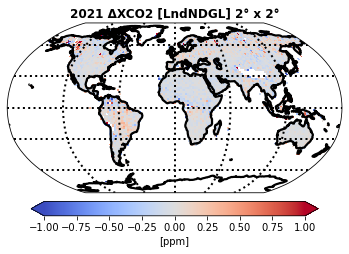

In [51]:
# xco2 diff plot
MIN = -1
MAX = 1
res = 2
deg = '\u00b0'
denominator, xedges, yedges = np.histogram2d(data_mlqf0['longitude'],data_mlqf0['latitude'],bins=[360//res, 180//res])
nominator, _, _, = np.histogram2d(data_mlqf0['longitude'],data_mlqf0['latitude'],bins=[xedges, yedges], weights=(data_mlqf0['xco2raw_SA_bias']))
result = nominator / denominator
result.clip(1)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1,
                     projection=ccrs.Robinson())
im = ax.imshow(result.T, interpolation='nearest', origin='lower',
                        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'coolwarm', vmin = -1, vmax = 1,transform=ccrs.PlateCarree())
ax.gridlines(linestyle='dotted', linewidth = 2, color = 'black')
ax.coastlines(color = 'black', linewidth = 2.2)
ax.set_title('2021 '+'\u0394' +'XCO2 [LndNDGL] 2'+deg+' x 2'+deg, fontweight = 'bold')
plt.colorbar(im, fraction=0.066, pad=0.04, extend='both', location = 'bottom', label='[ppm]')
plt.savefig('xco2_diff_min_rmse_mlqf0.png', dpi = 300)
plt.show()

<h2> Ternary MLQF with feature space distance (SA - TCCON)</h2>

In [150]:
# tcconRidgeDirString = '/Users/williamkeely/Desktop/B11/current/bias_models_current/current/V4_5_nofoot_noTCsplit_dws_xco2_TCCON_biasall_all_RF0/'  # path to 1st bias model directory
# rfDirString = '/Users/williamkeely/Desktop/B11/current/bias_models_current/current/V4_5_precRF_noTC_nofoot_noTCsplit_xco2raw_SA_biasall_all_RF0/'  # path to 2nd bias model directory
tcconRidgeDirString = '/Users/williamkeely/Desktop/B11/current/bias_models_current/region_specific_NDGL/V3_7_nofoot_noTCsplit_xco2_TCCON_biasLndNDGL_lnd_Ransac0/'  # path to 1st bias model directory
rfDirString = '/Users/williamkeely/Desktop/B11/current/bias_models_current/region_specific_NDGL/V3_7_precRansac_nofoot_noTCsplit_xco2raw_SA_biasLndNDGL_lnd_RF0/'  # path to 2nd bias model directory
qfModelDirString = '/Users/williamkeely/Desktop/B11/current/MLQF_models'

train_years = [2018,2019,2020]

data_train = generate_training_set(train_years=train_years,tccon_flag = False,mode='all',qf=None,preload_IO=True,footprint=0,Steffen_IO=False)
data_test = load_data(2021, 'all', verbose_IO=True, qf=None, preload_IO=True, footprint=0, Steffen_IO=False)

# set land fraction 0 = land, 1 = ocean
data_train = data_train[data_train['land_water_indicator'] == 0]
data_test = data_test[data_test['land_water_indicator'] == 0]

data_qf = data_test.copy(deep=True) # deep copy for plotting
data_qf = data_qf[data_qf['xco2_quality_flag'] == 0] # use to evaluate difference between MLQF and B11 QF
data_train['xco2_ret'] = data_train['xco2_raw']    
data_test['xco2_ret'] = data_test['xco2_raw']    
# make bias correction 1
vars = ['xco2_raw']
data_train = bias_correct(tcconRidgeDirString, data_train, vars)
data_test = bias_correct(tcconRidgeDirString, data_test, vars)

# make bias correction 2 # if we have a two step bias corr model
data_train = bias_correct(rfDirString, data_train, vars)
data_test = bias_correct(rfDirString, data_test, vars)

data_train['xco2MLcorr'] =  data_train['xco2_raw']
data_test['xco2MLcorr'] = data_test['xco2_raw'] 

# recalculate small area bias
data_test.sort_values('SA', inplace=True)
XCO2 = data_test.loc[:, 'xco2MLcorr'].to_numpy()
SA = data_test.loc[:, 'SA'].to_numpy()
data_test.loc[:, 'xco2raw_SA_bias'] = calc_SA_bias(XCO2, SA)

loading data from 2018...
loading data from 2019...
loading data from 2020...
loading data from 2021...
making predictions
making predictions
making predictions
making predictions
recalculating SA bias


In [151]:
data_train['TCCON_dist_SA'] = data_train['TCCON_dist_SA'] * 100
data_train['TCCON_dist_SA'].describe()

count    1.021625e+06
mean     6.035622e+00
std      5.222973e+00
min      1.759042e+00
25%      3.943749e+00
50%      4.700410e+00
75%      6.282086e+00
max      3.191147e+02
Name: TCCON_dist_SA, dtype: float64

In [156]:
# land vars
feats = ['co2_grad_del','dpfrac','aod_strataer','dp_o2a','h_continuum_sco2','aod_ice','ice_height','h_continuum_o2a','aod_sulfate','co2_ratio','albedo_sco2', 'rms_rel_wco2',
                   'rms_rel_sco2','footprint','solar_zenith_angle']


# create a list of our conditions
thresholds_train = [
    (np.abs(data_train['xco2raw_SA_bias']) > 0.77),
    ((np.abs(data_train['xco2raw_SA_bias']) > 0.77) | ((np.abs(data_train['xco2raw_SA_bias']) <= 0.55) & (np.abs(data_train['TCCON_dist_SA']) > 6.032))),
    ((np.abs(data_train['xco2raw_SA_bias']) <= 0.55) & (np.abs(data_train['TCCON_dist_SA']) <= 6.032 ))

    
    ]
thresholds_test = [
    (np.abs(data_test['xco2raw_SA_bias']) > 0.77),
    ((np.abs(data_test['xco2raw_SA_bias'] <= 0.77)) & (np.abs(data_test['xco2raw_SA_bias']) > 0.55)) | ((np.abs(data_test['xco2raw_SA_bias']) <= 0.55) & (np.abs(data_test['TCCON_dist_SA']) > 6.032 )),
    ((np.abs(data_test['xco2raw_SA_bias']) <= 0.55) & (np.abs(data_test['TCCON_dist_SA']) <= 6.032 ))

# + 5.184
    ]

# create a list of the values we want to assign for each condition
flags = [2,1,0]

# create a new column and use np.select to assign values to it using our lists as arguments
data_train['MLQF_true'] = np.select(thresholds_train, flags)
data_test['MLQF_true'] = np.select(thresholds_test,flags)



data_train = data_train.dropna(subset=['MLQF_true'])
data_test = data_test.dropna(subset=['MLQF_true'])

y_train = data_train['MLQF_true']
y_test = data_test['MLQF_true']

y_test.isnull().sum()

X_train = data_train[feats]
X_test = data_test[feats]



M = RandomForestClassifier(n_estimators=100,
                                   max_depth=12,
                                   max_samples=len(X_train)//2,
                                   min_samples_split=40,
                                   min_samples_leaf=10,
                                   min_weight_fraction_leaf=0.0,
                                   max_features='sqrt',
                                   max_leaf_nodes=None,
                                   min_impurity_decrease=0.0,
                                   bootstrap=True,
                                   oob_score=False,
                                   n_jobs=-1,
                                   random_state=None,
                                   verbose=1,
                                   warm_start=False,
                         class_weight = {0 : 3.0, 1 : 1.0}
                           #class_weight = {0 : 3.0, 1 : 1.5, 2 : 2.1}
                          )

In [157]:
# fit regressor
M.fit(X_train, y_train)
preds = M.predict(X_test)

data_test['MLQF'] = preds
print(data_test['MLQF'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.7s


12374       0
12416       0
12375       0
12439       2
12443       0
           ..
54034513    2
54034505    2
54034538    0
54048073    2
54048249    2
Name: MLQF, Length: 1648155, dtype: int64


[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    2.1s finished


In [158]:
data_mlqf0 = data_test[(data_test['MLQF'] == 0)]
data_mlqf1 = data_test[(data_test['MLQF'] == 1)]
data_mlqf = pd.concat([data_mlqf0,data_mlqf1])
print(get_RMSE(data_mlqf0['xco2raw_SA_bias']))
print(get_RMSE(data_mlqf1['xco2raw_SA_bias']))
print(get_RMSE(data_mlqf['xco2raw_SA_bias']))
# print(data_mlqf['xco2tccon'].std())
precision, recall, fscore, support = precision_recall_fscore_support(data_test['MLQF'], data_test['MLQF_true'])

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

print(len(data_mlqf0)/len(data_test) * 100)
print(len(data_mlqf1)/len(data_test) * 100)
print(len(data_mlqf)/len(data_test) * 100)

0.8778363442448877
0.7018752339937491
0.8775364671100767
precision: [0.80443926 0.00131338 0.40247107]
recall: [0.60716435 0.1167979  0.48867836]
fscore: [0.69201699 0.00259754 0.44140499]
support: [1204855    2286  441014]
73.10325788533238
0.13870054697525416
73.24195843230764


TCCON Stations :  ['' 'lauder03' 'saga01' 'lamont01' 'rikubetsu01' 'easttroutlake01'
 'nicosia01' 'izana01' 'tsukuba02' 'parkfalls01' 'paris01' 'burgos01'
 'bremen01' 'sodankyla01' 'karlsruhe01']

ML correction to tccon
STD: XCO2 corrected - XCO2 tccon: 1.1942141862464923
median: XCO2 corrected - XCO2 tccon: 0.02049465402808437

B11 to tccon
STD: XCO2bc - XCO2 tccon: 1.2512147285831132
median: XCO2bc - XCO2 tccon: 0.0567626953125

Raw to tccon
STD: XCO2bc - XCO2 tccon: 1.1942141862464923
median: XCO2bc - XCO2 tccon: 0.02049465402808437
ML-TCCON RMSE QF = 0 :  1.1945870117416004


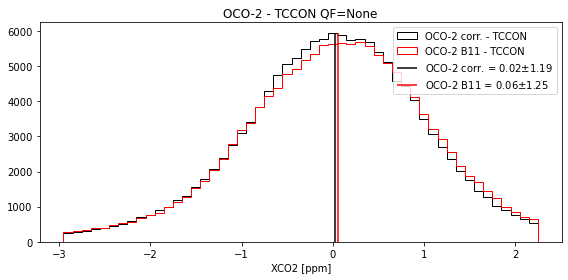

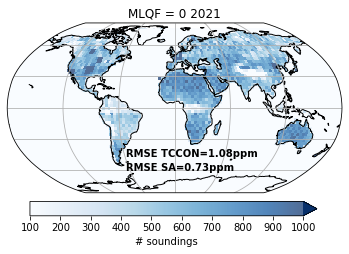

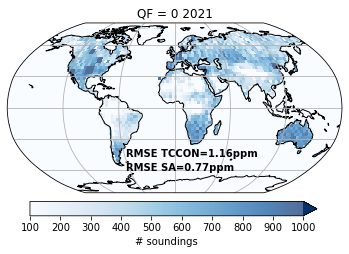

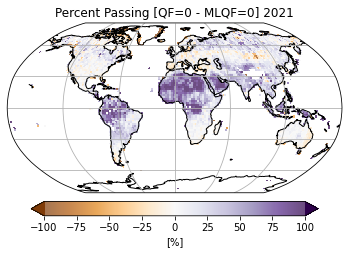

In [159]:
TCCON_names = data_test['tccon_name'].unique()
holdout_set = ['parkfalls01','lamont01','saga01','tsukuba02','burgos01']
TCCON_names = TCCON_names[TCCON_names != 'pasadena01']
TCCON_names = TCCON_names[TCCON_names != 'xianghe01']
# TCCON_names = TCCON_names[np.isin(TCCON_names,holdout_set)]
print('TCCON Stations : ', TCCON_names)

xco2ML_std, xco2ML_mean, xco2B11_std, xco2B11_mean, xco2raw_std, xco2raw_mean, xco2ML_RMSE_QF0, xco2B11_RMSE, xco2raw_RMSE = plot_tccon(data_mlqf0,
                                                                                               TCCON_names,
                                                                                               save_fig=True,
                                                                                               path='/Users/williamkeely/Desktop/',
                                                                                               name='TCCON_rmse_mlqf0_min.png')

print('ML-TCCON RMSE QF = 0 : ', xco2ML_RMSE_QF0)

import cartopy.crs as ccrs
# plt.rcParams["figure.figsize"] = (10,7)


result, xedges, yedges = np.histogram2d(data_mlqf0['longitude'],data_mlqf0['latitude'],bins=[120, 60])
result = result.clip(1)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1,
                         projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
fig.text(x = 0.40,y=0.33, s = 'RMSE TCCON=1.08ppm', fontsize = 10, weight = 'bold')
fig.text(x = 0.40,y=0.28, s = 'RMSE SA=0.73ppm', fontsize = 10, weight = 'bold')

im = ax.imshow(result.T, interpolation='nearest', origin='lower',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Blues',vmin = 100, vmax = 1000, transform=ccrs.PlateCarree(), alpha = 0.7)

ax.set_title("MLQF = 0 2021")
plt.colorbar(im, fraction=0.066, pad=0.04, extend='max', location = 'bottom', label='# soundings')
plt.savefig("mlqf_binary_min_rmse.png", dpi = 200)
plt.show()



result, xedges, yedges = np.histogram2d(data_qf['longitude'],data_qf['latitude'],bins=[120, 60])
result = result.clip(1)
fig = plt.figure()
fig.text(x = 0.40,y=0.33, s = 'RMSE TCCON=1.16ppm', fontsize = 10, weight = 'bold')
fig.text(x = 0.40,y=0.28, s = 'RMSE SA=0.77ppm', fontsize = 10, weight = 'bold')
ax = fig.add_subplot(1, 1, 1,
                         projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
im = ax.imshow(result.T, interpolation='nearest', origin='lower',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Blues',vmin = 100, vmax = 1000, transform=ccrs.PlateCarree(), alpha = 0.7)

ax.set_title("QF = 0 2021")
plt.colorbar(im, fraction=0.066, pad=0.04, extend='max', location = 'bottom', label='# soundings')
plt.show()

plot_qf_map(data_qf, data_mlqf0, None,year = '2021', save_fig=True, path='/Users/williamkeely/Desktop/', name='mlqf01_min_rmse_diff',diff = True, statistic = 'mean')